✅ 第1段：数据准备与三维可视化（已知7点 + 组合后橘黄色点预留）

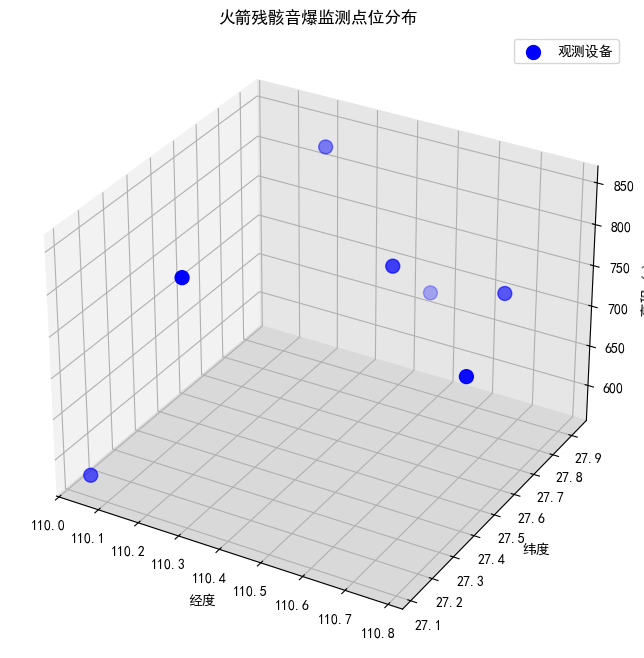

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams

# 设置字体以支持中文显示
rcParams['font.family'] = 'SimHei'  # 黑体
rcParams['axes.unicode_minus'] = False  # 正常显示负号
# 设备数据定义
stations = {
    'A': [110.241, 27.204, 824, 100.767],
    'B': [110.780, 27.456, 727, 112.220],
    'C': [110.712, 27.785, 742, 188.020],
    'D': [110.251, 27.825, 850, 258.985],
    'E': [110.524, 27.617, 786, 118.443],
    'F': [110.467, 27.921, 678, 266.871],
    'G': [110.047, 27.121, 575, 163.024]
}

station_names = list(stations.keys())
station_data = np.array([stations[name] for name in station_names])  # shape: (7, 4)
station_pos = station_data[:, :3]
station_time = station_data[:, 3]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.grid(True)

# 设置不同灰度的背景面
ax.xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
ax.yaxis.set_pane_color((0.9, 0.9, 0.9, 1.0))
ax.zaxis.set_pane_color((0.85, 0.85, 0.85, 1.0))

# 绘制7个设备点
ax.scatter(station_pos[:, 0], station_pos[:, 1], station_pos[:, 2], 
           c='blue', s=100, label='观测设备')

ax.set_xlabel('经度')
ax.set_ylabel('纬度')
ax.set_zlabel('高程 (m)')
ax.set_title('火箭残骸音爆监测点位分布')

plt.legend()
plt.show()


✅ 第2段：组合计算35种声源位置与时间（C(7,4)）

In [3]:
import pandas as pd
from itertools import combinations
from scipy.optimize import least_squares
import numpy as np

# 设置输出精度：禁用科学计数法
np.set_printoptions(suppress=True, precision=6)

# 地球半径 (km)，音速 (km/s)
R = 6371.0
c = 0.343  # km/s

# 原始数据
data = {
    '设备': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    '经度': [110.241, 110.780, 110.712, 110.251, 110.524, 110.467, 110.047],
    '纬度': [27.204, 27.456, 27.785, 27.825, 27.617, 27.921, 27.121],
    '高度': [824, 727, 742, 850, 786, 678, 575],  # 单位 m
    '时间': [100.767, 112.220, 188.020, 258.985, 118.443, 266.871, 163.024]
}

df = pd.DataFrame(data)

# 经纬度 → 平面坐标（单位 km）
df['x'] = R * np.cos(np.radians(df['纬度'])) * np.radians(df['经度'])
df['y'] = R * np.radians(df['纬度'])
df['z'] = df['高度'] / 1000

# 残差函数
def residual(vars, xyz, times):
    x0, y0, z0, t0 = vars
    d = np.sqrt((xyz[:, 0] - x0) ** 2 + (xyz[:, 1] - y0) ** 2 + (xyz[:, 2] - z0) ** 2)
    return d / c + t0 - times

# 拟合35种组合
results = []
for combo in combinations(df.index, 4):
    points = df.loc[list(combo)]
    xyz = points[['x', 'y', 'z']].values
    times = points['时间'].values

    guess = np.append(xyz.mean(axis=0), times.min() - 1)
    res = least_squares(residual, guess, args=(xyz, times))

    if res.success:
        results.append(res.x)

# 转换为 DataFrame，保留小数格式
result_df = pd.DataFrame(results, columns=['x(km)', 'y(km)', 'z(km)', 't0(s)'])
pd.set_option('display.float_format', '{:.6f}'.format)  # 全局禁止科学计数法
print(result_df)


           x(km)          y(km)         z(km)           t0(s)
0   10933.895852    3006.027385    104.049911     -218.772166
1   10906.328153    3045.098140      0.816918       39.549608
2   10921.798752    3023.790324    -62.565167      -92.626383
3   10910.756228    3045.183949      1.358979       48.273332
4   10905.045717    3046.629650    -13.049525       25.289677
5  128230.304203 -169054.496463 274046.049434 -1003416.848516
6   10905.674689    3051.310795      1.710903       37.095216
7   10905.670768    3046.740343      0.864918       36.696361
8   10906.965467    3049.782451      1.401439       40.381725
9   10907.624127    3048.900749      1.552433       42.083197
10  10894.369950    3042.801510      0.831770       43.966705
11  10892.523429    3040.767720      2.213344       46.350295
12  10899.394984    3046.639569      2.292889       52.198801
13  10896.795814    3043.288997      0.854823       45.067844
14  10906.885923    3047.467665      1.129590       46.012522
15  1090

✅ 第3段：三维图中绘制35个计算出的声源点（橘黄色小点）

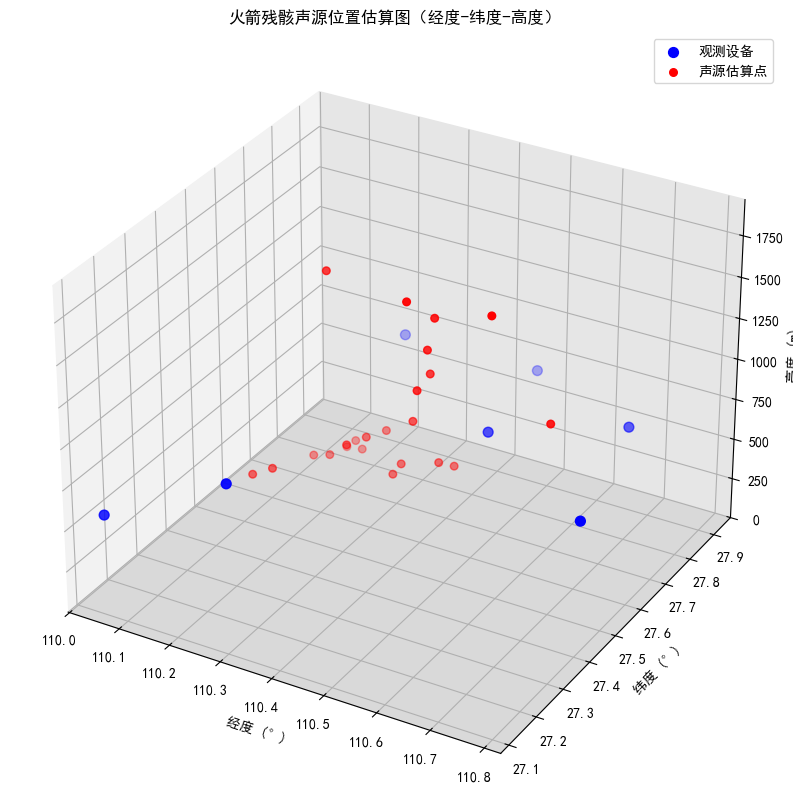

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 地球半径 (km)
R = 6371.0

# ========== 1. 定义坐标转换函数 ========== #
def xy_to_lonlat(x, y):
    """将平面 x, y (km) 转换为经纬度（°）"""
    lat = np.degrees(y / R)
    lon = np.degrees(x / (R * np.cos(np.radians(lat))))
    return lon, lat

# ========== 2. 反算声源点经纬度，单位保留 ========== #
# 过滤异常值（高度和时间不合理）
filtered_df = result_df[
    (result_df['t0(s)'] > 0) & (result_df['t0(s)'] < 200) &
    (result_df['z(km)'] > 0) & (result_df['z(km)'] < 2)
].copy()

# z 转换为高度 m
filtered_df['z(m)'] = filtered_df['z(km)'] * 1000

# 反算为经纬度
filtered_df['经度'], filtered_df['纬度'] = xy_to_lonlat(
    filtered_df['x(km)'], filtered_df['y(km)']
)

# 原观测设备点也准备好（直接使用 df）
df['高度(m)'] = df['高度']  # 单位 m
x_known = df['经度'].values
y_known = df['纬度'].values
z_known = df['高度(m)'].values

x_est = filtered_df['经度'].values
y_est = filtered_df['纬度'].values
z_est = filtered_df['z(m)'].values

# ========== 3. 自动设定坐标轴范围 ========== #
x_min, x_max = min(x_known.min(), x_est.min()), max(x_known.max(), x_est.max())
y_min, y_max = min(y_known.min(), y_est.min()), max(y_known.max(), y_est.max())
z_min, z_max = 0, max(z_known.max(), z_est.max()) + 100

# ========== 4. 绘图 ========== #
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.grid(True)

# 灰色立体背景
ax.xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
ax.yaxis.set_pane_color((0.9, 0.9, 0.9, 1.0))
ax.zaxis.set_pane_color((0.85, 0.85, 0.85, 1.0))

# 绘制蓝色观测点
ax.scatter(x_known, y_known, z_known, c='blue', s=50, label='观测设备')

# 绘制橘黄色声源点
ax.scatter(x_est, y_est, z_est, c='red', s=30, label='声源估算点')

# 坐标轴设置
ax.set_xlim(x_min - 0.05, x_max + 0.05)
ax.set_ylim(y_min - 0.05, y_max + 0.05)
ax.set_zlim(z_min, z_max)

ax.set_xlabel('经度 (°)')
ax.set_ylabel('纬度 (°)')
ax.set_zlabel('高度 (m)')
ax.set_title('火箭残骸声源位置估算图（经度-纬度-高度）')

plt.legend()
plt.show()


✅ 第4段：输出35个声源估算点的经纬度、高度（m）、发生时间 t₀

In [5]:
# 设置全局禁止科学计数法，保留6位小数
pd.set_option('display.float_format', '{:.6f}'.format)

# 添加时间列
filtered_df['t0(s)'] = filtered_df['t0(s)']

# 选择并重命名列，方便查看和导出
output_df = filtered_df[['经度', '纬度', 'z(m)', 't0(s)']].copy()
output_df.rename(columns={'z(m)': '高度(m)', 't0(s)': '发生时间(s)'}, inplace=True)

# 打印结果
print(output_df)


           经度        纬度       高度(m)   发生时间(s)
1  110.461997 27.385225  816.918164 39.549608
3  110.507617 27.385997 1358.979156 48.273332
6  110.511256 27.441097 1710.903342 37.095216
7  110.470093 27.399994  864.918394 36.696361
8  110.510573 27.427353 1401.438575 40.381725
9  110.509311 27.419423 1552.433433 42.083197
10 110.320287 27.364571  831.769864 43.966705
13 110.349223 27.368955  854.822932 45.067844
14 110.488941 27.406535 1129.589528 46.012522
15 110.479743 27.401215 1834.173439 47.855960
16 110.408874 27.389382  985.839998 40.395131
18 110.612776 27.450176 1799.615897 23.747680
19 110.722167 27.454401 1256.866288  5.714017
20 110.269260 27.244678  847.288948  2.314433
23 110.297485 27.263076  882.196762  8.156699
24 110.526589 27.428638  882.597083 49.051227
26 110.394178 27.347075  988.365030 24.958592
29 110.543726 27.452323  841.361138 45.275050
30 110.365820 27.430418  864.475832 66.495036
31 110.350994 27.425891  819.881958 64.316857
32 110.321630 27.412887 1865.40321

✅ 第5段：统计分析——计算经度、纬度、高度、发生时间的均值 (u) 和标准差 (s)

In [6]:
def remove_outliers(df, columns, std_factor=3):
    df_clean = df.copy()
    for col in columns:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        lower = mean - std_factor * std
        upper = mean + std_factor * std
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

# 剔除异常值（3倍标准差原则）
cols = ['经度', '纬度', '高度(m)', '发生时间(s)']
clean_df = remove_outliers(output_df, cols, std_factor=3)

# 再做统计分析
stats_clean = clean_df.agg(['mean', 'std']).rename(index={'mean': '均值 (u)', 'std': '标准差 (s)'})
print("剔除异常值后的统计分析：")
print(stats_clean)


剔除异常值后的统计分析：
                经度        纬度       高度(m)   发生时间(s)
均值 (u)  110.444570 27.398362 1138.708083 41.233156
标准差 (s)   0.108373  0.053968  374.287106 18.368108


✅ 第6段：绘制经度、纬度、高度、发生时间的正态分布图

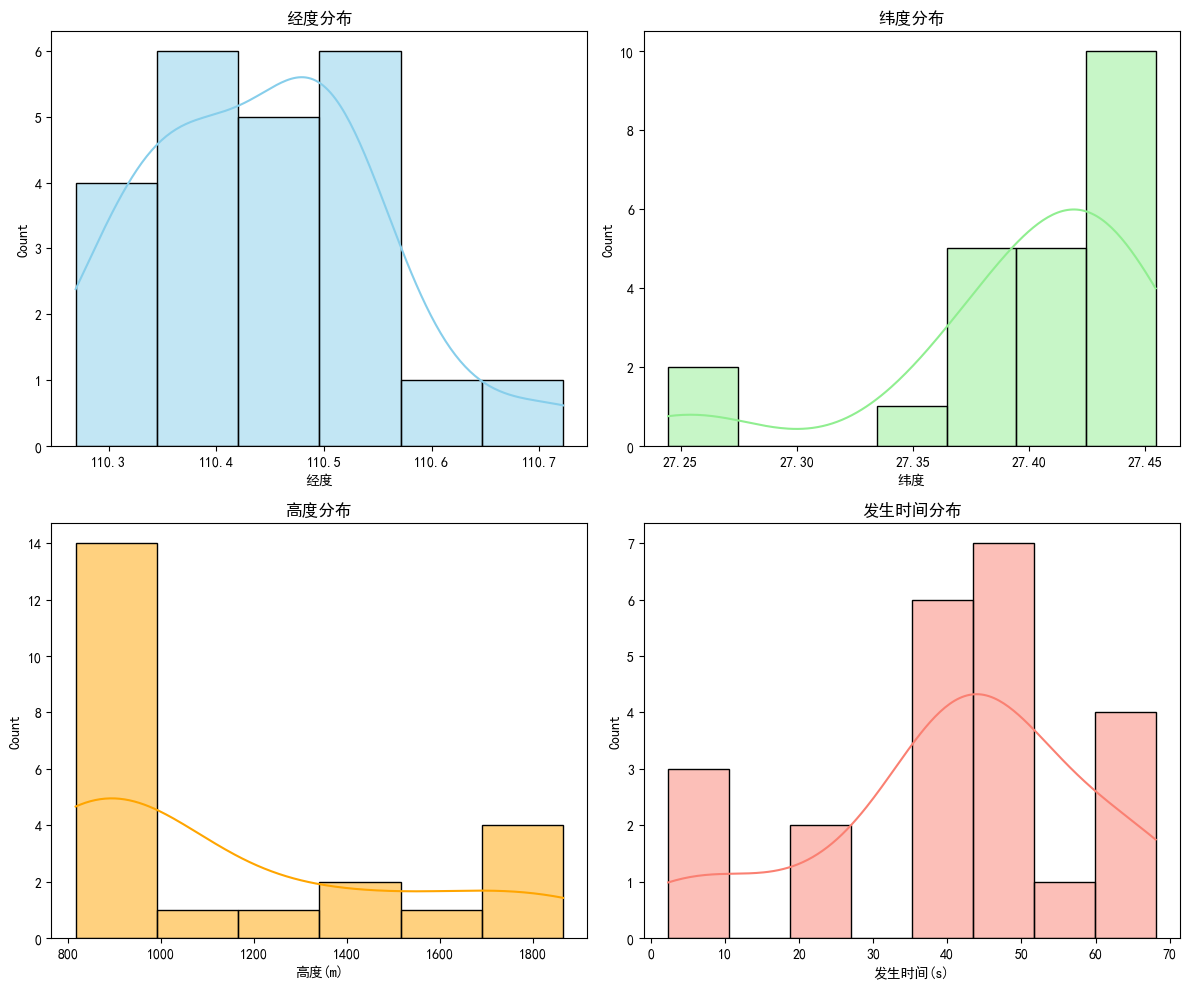

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用剔除异常值后的 clean_df

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(clean_df['经度'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('经度分布')

sns.histplot(clean_df['纬度'], kde=True, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('纬度分布')

sns.histplot(clean_df['高度(m)'], kde=True, ax=axes[1, 0], color='orange')
axes[1, 0].set_title('高度分布')

sns.histplot(clean_df['发生时间(s)'], kde=True, ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('发生时间分布')

plt.tight_layout()
plt.show()
